In [1]:
# Imports for JupyterLite
%pip install -q ipywidgets requests

In [2]:
import ipywidgets as widgets
from IPython.display import display
import pyodide_http

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from matplotlib.gridspec import GridSpec
import requests

pyodide_http.patch_all()

FigureSize = (8, 12)
TickLoc = plticker.MultipleLocator(base=0.5)

In [3]:
file = widgets.FileUpload(
    accept=".gef, .GEF",  # Accepted file extension
    multiple=False,  # True to accept multiple files upload else False
    disabled=False,
)
authorization = widgets.Password(
    value=None,
    placeholder='Enter Personal Access Token',
    description='Authorization:',
    disabled=False
)
classify = widgets.Dropdown(
    options=['beenJefferies', 'machineLearning', 'nen', 'table', 'robertson', 'table'],
    value='nen',
    description='Classification methode:',
    disabled=False
)


In [4]:
display(file)
display(authorization)
display(classify)

FileUpload(value=(), accept='.gef, .GEF', description='Upload')

Password(description='Authorization:', placeholder='Enter Personal Access Token')

Dropdown(description='Classification methode:', index=2, options=('beenJefferies', 'machineLearning', 'nen', '…

In [5]:
if not len(file.value) > 1:
    raise ValueError("Please provide a file first!")


payload = {
    "content": file.value[0].content.tobytes().decode(encoding='iso8859-1'),
    "engine": "gef"
}

parse_response = requests.post(
    "https://crux-nuclei.com/api/cptcore/v1/parse/cpt",
    json=payload,
    headers=to_js({
        'Authorization': f'Bearer {authorization.value}',
    })
)

if not parse_response.ok:
    raise RuntimeError(parse_response.content)

data = parse_response.json()

transform_response = requests.get(f"https://epsg.io/trans?s_srs=4326&t_srs=28992&x={data['location']['long']}&y={data['location']['lat']}&format=json")
location = json.loads(transform_response.text)

payload = {
    "aggregateLayersPenalty": 3,
    "data": {
        "coneResistance": data["data"]["coneResistance"],
        "correctedPenetrationLength": data["data"]["penetrationLength"],
    },
    "verticalPositionOffset": data["verticalPositionOffset"],
    "x": location["x"],
    "y": location["y"],
}

if "localFriction" in data["data"].keys():
    payload["data"]["localFriction"] = data["data"]["localFriction"]

classify_response = requests.post(
    f"https://crux-nuclei.com/api/cptcore/v1/classify/{classify.value}",
    json=payload,
    headers=to_js({
        'Authorization': f'Bearer {authorization.value}',
    })
)

if not classify_response.ok:
    raise RuntimeError(parse_response.content)

<class 'ValueError'>: Please provide a file first!

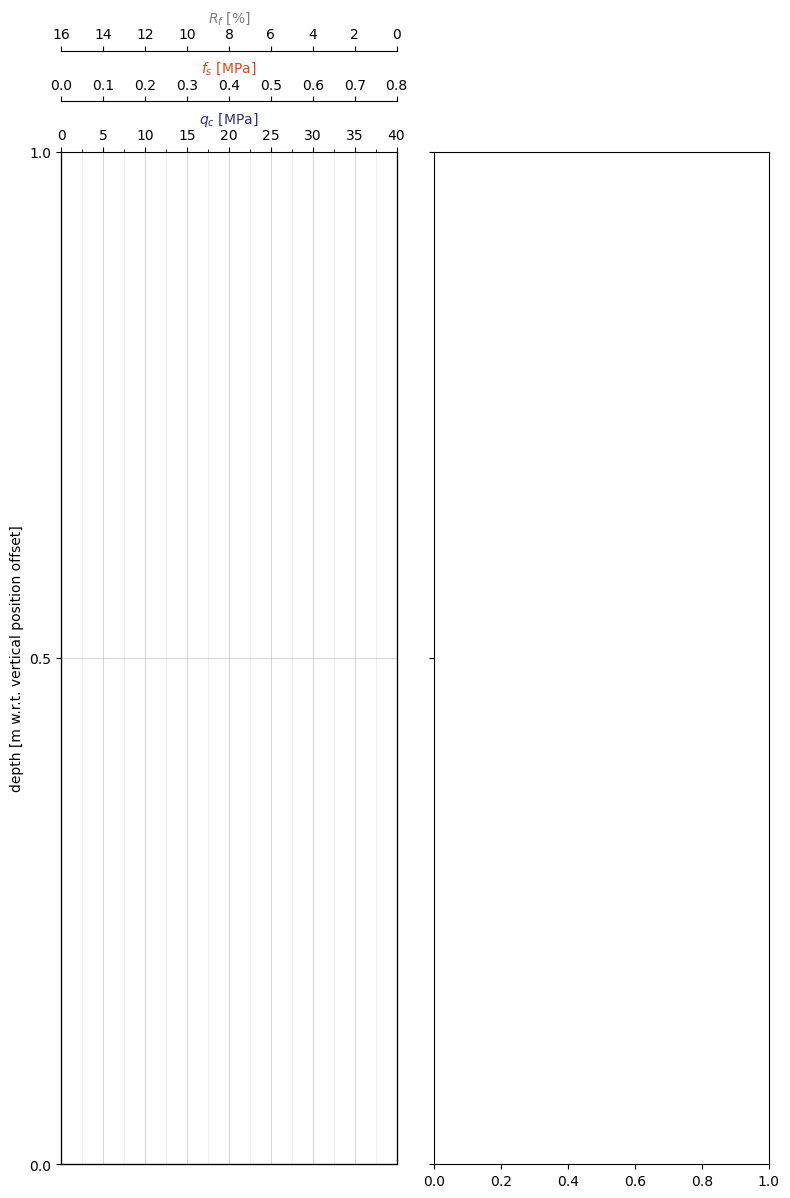

<class 'NameError'>: name 'data' is not defined

In [6]:
fig = plt.figure(figsize=FigureSize, dpi=100, layout="tight")
ax11, ax21 = fig.subplots(1, 2, sharey=True)

p1 = None
p11 = None
p12 = None
ax12 = ax11.twiny()
p2 = None
ax13 = ax11.twiny()
p3 = None
p4 = None

axes = (ax11, ax12, ax13)

# set the properties on the coneResistance axes
ax11.xaxis.set_ticks_position("top")
ax11.xaxis.set_label_position("top")
ax11.spines["top"].set_position(("axes", 1))
ax11.set_xlim(0, 40)
ax11.set_xlabel("$q_c$ [MPa]")
ax11.xaxis.label.set_color("#2d2e87")
ax11.set_ylabel("depth [m w.r.t. vertical position offset]")

# create grid
major_ticks = np.arange(0, 41, 5)
minor_ticks = np.arange(0, 41, 2.5)
ax11.set_xticks(major_ticks)
ax11.set_xticks(minor_ticks, minor=True)
ax11.grid(which="both")
ax11.grid(which="minor", alpha=0.2)
ax11.grid(which="major", alpha=0.5)
ax11.yaxis.set_major_locator(TickLoc)

# set the properties on the localFriction axes
ax12.xaxis.set_ticks_position("top")
ax12.xaxis.set_label_position("top")
ax12.spines["top"].set_position(("axes", 1.05))
ax12.set_xlabel("$f_s$ [MPa]")
ax12.set_xlim(0, 0.8)
ax12.xaxis.label.set_color("#e04913")

# set the properties on the frictionRatio axes
ax13.xaxis.set_ticks_position("top")
ax13.xaxis.set_label_position("top")
ax13.spines["top"].set_position(("axes", 1.1))
ax13.set_xlabel("$R_f$ [%]")
ax13.set_xlim(0, 16)
ax13.invert_xaxis()
ax13.xaxis.label.set_color("tab:gray")

# add data to figure
# plot coneResistance
if "coneResistance" in data["data"].keys():
    (p1,) = ax11.plot(
        data["data"]["coneResistance"], 
        data["data"]["depthOffset"], 
        color="#2d2e87", 
        label="coneResistance"
    )
# plot localFriction
if "localFriction" in data["data"].keys():
    (p2,) = ax12.plot(
        data["data"]["localFriction"], 
        data["data"]["depthOffset"], 
        color="#e04913", 
        label="localFriction"
    )

# plot measured frictionRatio
if "frictionRatio" in data["data"].keys():
    (p3,) = ax13.plot(
        data["data"]["frictionRatio"],
        data["data"]["depthOffset"],
        label="frictionRatio measured",
        color="tab:gray",
    )

# plot computed frictionRatio
if "frictionRatioComputed" in data["data"].keys():
    (p4,) = ax13.plot(
        data["data"]["frictionRatioComputed"],
        data["data"]["depthOffset"],
        label="frictionRatio computed",
        ls="dashed",
        color="tab:gray",
    )
# add hlines
if data["groundwaterLevel"] is not None:
    value = data["verticalPositionOffset"] - data["groundwaterLevel"]
    p11 = ax11.axhline(
        value,
        label=f"groundwater level: {value:.2f}",
        color="tab:blue",
        ls="dashed",
    )
if data["predrilledDepth"] is not None:
    value = data["verticalPositionOffset"] - data["predrilledDepth"]
    p12 = ax11.axhline(
        value,
        label=f"predrilled depth: {value:.2f}",
        color="tab:brown",
        ls="dashed",
    )

# add legend
ax11.legend(
    loc="upper center",
    title=f"CPT: {data['label']}",
    handles=[i for i in [p1, p2, p3, p4, p11, p12] if i is not None],
)


# add classify
table = classify_response.json()
for top, bottom, color, name in zip(
    table["lowerBoundary"], 
    table["upperBoundary"], 
    table["color"], 
    table["geotechnicalSoilName"]
):
    top = data["verticalPositionOffset"] - top
    bottom = data["verticalPositionOffset"] - bottom
    ax21.fill_between(
        [0, 1],
        top,  # type: ignore
        bottom,  # type: ignore
        color=color,  # type: ignore
    )

    # add annotate
    y = (bottom - top) / 2 + top # type: ignore
    ax21.annotate(
        text=name,  # type: ignore
        xy=(0.25, y),
        fontsize=5,
    )